# Some thoughts

In the last studies (e.g. from 2019.12.20) you see that your public score is always around 0.9 while local validation reaches rmse of 0.8.

Two possibilities (not mutually exclusive) are:
* inaccurate forecast due to some more feature still not used (e.g. revenues)
* some of ~300 items (out of 5100) that you never saw selling may be selling on the forecast date



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Load data
train_df = pd.read_csv("../sales_train.csv.gz")
test_df  = pd.read_csv("../test.csv.gz")

categories = pd.read_csv('../item_categories.csv')
items = pd.read_csv('../items.csv')
shops = pd.read_csv('../shops.csv')

In [2]:
%store -r __prepare_data_4

In [3]:
%%time
__prepare_data_4

CPU times: user 2min 45s, sys: 1min 28s, total: 4min 14s
Wall time: 4min 17s


In [4]:
# based on tables from 2019.11.16/trends_combined.ipynb I choose those shops to be taken out:
closed_shops = [0, 1, 8, 9, 11, 13, 17, 20, 23,  27,  29, 30, 32, 33,  36,  40, 43, 54]

# one of those, though, needs to be predicted (#36):
print(test_df[test_df.shop_id.isin(closed_shops)].shop_id.unique())

# and one of those (#51) does not (keep it for training anyways):
print(set(all_data.shop_id.unique()).difference(test_df.shop_id.unique()))

# this explains why shop #36 is not a good shop:
(all_data[all_data.shop_id == 36]
             .groupby(["date_block_num"])
             .agg({'total_monthly_shop_sales': lambda x: np.NA if x.empty else x.iloc[0]})
             .reset_index())

[36]
{0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54}


,date_block_num,total_monthly_shop_sales
0,33,0.060964
1,34,0.000000


In [5]:
# from cell 14 of 2019.11.16/trends_combined.ipynb

print("Total number of items is %d, among those sold are %d" % \
      (len(items.item_id), len(train_df.item_id.unique())) )

items_never_sold = set(items.item_id.unique().tolist()).difference(set(train_df.item_id.unique()))

print("Items never sold %d" % len(items_never_sold) )

print("Unknown items to predict: %d" % len(set(test_df.item_id.unique()).difference(set(items.item_id.unique()))))

print("Unsold items to predict: %d" % len(set(test_df.item_id.unique()).intersection(set(items_never_sold))))

print("Known items not to bother about: %d" % len(set(items.item_id.unique()).difference(set(test_df.item_id.unique()))))

print("I.e., to predict: %d out of %d items" % (len(test_df.item_id.unique()), len(set(items.item_id.unique()))))

cat_of_unsold_items = items[ items.item_id.isin(list(items_never_sold))].item_category_id.unique()
cat_of_sold_items   = items[~items.item_id.isin(list(items_never_sold))].item_category_id.unique()

print("Categories of sold (%d) and unsold (%d) items: %d out of %d categories" % \
      (len(cat_of_sold_items),len(cat_of_unsold_items),len(set(cat_of_unsold_items).intersection(set(cat_of_sold_items))), len(categories)))

print("Categories of items to predict: %d" % len(items[ items.item_id.isin(test_df.item_id.unique()) ].item_category_id.unique()))

Total number of items is 22170, among those sold are 21807
Items never sold 363
Unknown items to predict: 0
Unsold items to predict: 363
Known items not to bother about: 17070
I.e., to predict: 5100 out of 22170 items
Categories of sold (84) and unsold (39) items: 39 out of 84 categories
Categories of items to predict: 62


In [6]:
from calendar import monthrange

# January, 2013 is date_block_num==0
timeline = pd.DataFrame({'begin_date': pd.date_range(start='2013-01-01',end='2015-11-01', freq='MS'),
                         'date_block_num': range(35)} )
    
timeline['n_days'] = timeline.begin_date.apply(lambda date: monthrange(date.year,date.month)[1])

timeline['workdays'] = [17, 20, 20, 22, 18, 19, 23, 22, 21, 23, 20, 22,
                        17, 20, 20, 22, 19, 19, 23, 21, 22, 23, 18, 23,
                        15, 19, 21, 22, 18, 21, 23, 21, 22, 22, 20]

timeline['month_num'] = timeline['date_block_num'] % 12

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


CPU times: user 4min 27s, sys: 3.56 s, total: 4min 31s
Wall time: 4min 32s


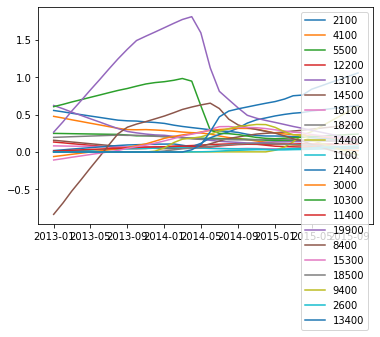

In [7]:
%%time
# the idea is to aggregate rarely sold items over larger periods (e.g. quarters) also identifying discontinued items
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_item = pd.DataFrame()
no_stock_items = []
discontinued_items = []

total_monthly_item_sales_good = (all_data[~ all_data.shop_id.isin(closed_shops)]
                                 .groupby(["date_block_num", "item_id"]).agg({'target': [np.mean, sum]})).reset_index()

total_monthly_item_sales_good.columns = ["date_block_num", "item_id", "average_sales", "total_sales"]

for item in total_monthly_item_sales_good.item_id.unique(): #[1:30]:

    sales = (total_monthly_item_sales_good[total_monthly_item_sales_good.item_id==item]
             .groupby(["date_block_num"])
             .agg({'average_sales': lambda x: np.NA if x.empty else x.iloc[0],
                   'total_sales':   lambda x: np.NA if x.empty else x.iloc[0]})
             .reset_index())

    if not len(sales.index):
        continue

    sales = pd.merge(sales[["average_sales", "total_sales", "date_block_num"]],
                     timeline,
                     how='right',
                     on=['date_block_num']).sort_values(by=['date_block_num'])

    start = sales.iloc[min( np.where(~ np.isnan(sales.average_sales))[0] ),].date_block_num
    end   = sales.iloc[max( np.where(~ np.isnan(sales.average_sales))[0] ),].date_block_num
#    print("start: %d, end: %d" % (start,end))

    # last months sales are present, but not enough lags for seasonal inference => ignore
    if start+12 >= end:
        no_stock_items.append(item)
        continue

    # there should be sales in last month, otherwise consider it is discontinued
    if end < 33:
        discontinued_items.append(item)
        continue
        
    # at least last 3 month with sales should be present
    if sum(~ np.isnan(sales.average_sales[-3:])) < 3:
        no_stock_items.append(item)
        continue

    sales = sales[sales.date_block_num < 34].fillna(0) # month 34 does not have anything

#    print(sales)
    ts = pd.Series(sales.average_sales.values, index=sales["begin_date"])

    decomposition = seasonal_decompose(ts, extrapolate_trend=1, freq=12)

    trend    = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    if (item % 100) == 0:
        plt.plot(trend, label=item)

    decomposition_item = pd.concat([decomposition_item,
                             pd.DataFrame({
                                 'date_block_num':  sales.date_block_num,
                                 'item_id':         [item]*len(ts),
                                 'item_trend':      trend.values,
                                 'item_seasonal':   seasonal.values,
                                 'item_forecast':   trend.values + seasonal.values
                             })])

plt.legend(loc='best')

#all_data[all_data.shop_id.isin(strange_shops)]

In [8]:
print("Forecastable are %d items" % len(decomposition_item.item_id.unique()))

print("Among those only %d are needed for submission" % \
      len(set(test_df.item_id.unique()).intersection(set(decomposition_item.item_id.unique()))))
      
print("Discontinued are %d out of which %d need submission!" % \
      (len(discontinued_items), len(set(test_df.item_id.unique()).intersection(set(discontinued_items)))))

print("Not easily forecastable are %d items with %d needed for submission" % \
      (len(no_stock_items),len(set(test_df.item_id.unique()).intersection(set(no_stock_items)))))

Forecastable are 1917 items
Among those only 1917 are needed for submission
Discontinued are 7082 out of which 0 need submission!
Not easily forecastable are 13171 items with 3183 needed for submission


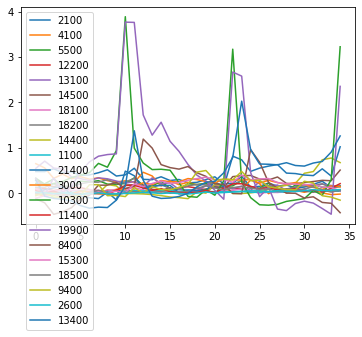

In [9]:
# extrapolate one point ahead basing on 3 points behind (note, all coordinates are relative):
extrapolate = lambda x: np.poly1d( np.polyfit([1,2,3], [x.iloc[-3],x.iloc[-2],x.iloc[-1]], 1) )(4)
#extrapolate.__name__ = "shop_trend"

trend_34 = decomposition_item.groupby(["item_id"]).agg({"item_trend": extrapolate})
trend_34.columns = ["item_trend"]
trend_34.reset_index()

seasonal_22 = decomposition_item[decomposition_item.date_block_num==(34-12)][['item_id','item_seasonal']]

forecast_34 = pd.merge(trend_34, seasonal_22, how='inner', on=['item_id'])
forecast_34['date_block_num'] = 34
forecast_34['item_forecast'] = forecast_34['item_trend'] + forecast_34['item_seasonal']

decomposition_item = pd.concat([decomposition_item, forecast_34], sort=True, ignore_index=True)

for item in decomposition_item.item_id.unique():
    if (item % 100) == 0:
        plt.plot(decomposition_item[decomposition_item.item_id == item].date_block_num.values,
                 decomposition_item[decomposition_item.item_id == item].item_forecast.values,
                 label=item)

plt.legend(loc='upper left')

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

train_ref = all_data[(all_data.date_block_num>11)&(all_data.date_block_num<33)].fillna(0)

train_ref = train_ref[(train_ref.shop_id!=51)|(train_ref.date_block_num<33)]

train_ref['date_block_num'] = train_ref['date_block_num'].astype(np.float32)

X_train_other_ref = train_ref[(train_ref.date_block_num <  32)][predictors] # + ['n_days','workdays']]
X_valid_other_ref = train_ref[(train_ref.date_block_num == 32)][predictors] # + ['n_days','workdays']]
y_train_other_ref = train_ref[(train_ref.date_block_num <  32)].target
y_valid_other_ref = train_ref[(train_ref.date_block_num == 32)].target

model_other_ref = RandomForestRegressor(n_estimators=64, max_features=6, n_jobs=6, random_state=123)
model_other_ref.fit(X_train_other_ref, y_train_other_ref)

ypred_other = model_other_ref.predict(X_valid_other_ref)
rmse = np.sqrt(mean_squared_error(y_valid_other_ref, ypred_other))
print("RMSE other: %f" % (rmse))
print("Average other: {0}".format(np.mean(ypred_other)))

RMSE other: 0.903499
Average other: 0.31840477864672656


In [11]:
train_ref = all_data[(all_data.date_block_num>11)&(all_data.date_block_num<33)&(~all_data.shop_id.isin(closed_shops))].fillna(0)

train_ref = train_ref[(train_ref.shop_id!=51)|(train_ref.date_block_num<33)]

train_ref['date_block_num'] = train_ref['date_block_num'].astype(np.float32) #.astype(np.int8)

X_train_other_ref = train_ref[(train_ref.date_block_num <  32)][predictors] # + ['n_days','workdays']]
X_valid_other_ref = train_ref[(train_ref.date_block_num == 32)][predictors] # + ['n_days','workdays']]
y_train_other_ref = train_ref[(train_ref.date_block_num <  32)].target
y_valid_other_ref = train_ref[(train_ref.date_block_num == 32)].target

model_other_ref = RandomForestRegressor(n_estimators=64, max_features=6, n_jobs=6, random_state=123)
model_other_ref.fit(X_train_other_ref, y_train_other_ref)

ypred_other = model_other_ref.predict(X_valid_other_ref)
rmse = np.sqrt(mean_squared_error(y_valid_other_ref, ypred_other))
print("RMSE other: %f" % (rmse))
print("Average other: {0}".format(np.mean(ypred_other)))

RMSE other: 0.910533
Average other: 0.32044923795476893


In [11]:
train = all_data[(all_data.date_block_num>11)&(all_data.date_block_num<34)&(~all_data.shop_id.isin(closed_shops))].fillna(0)
train = pd.merge(train, timeline, how='left', on=['date_block_num'])

train = pd.merge(train, decomposition_item, how='left', on=['date_block_num','item_id'])

# shop 51 is a special case as it is one point short
train = train[(train.shop_id!=51)|(train.date_block_num<33)]

predictors2 = predictors + ['item_forecast', 'item_trend', 'item_seasonal', 'n_days', 'workdays', 'month_num']

predictors3 = predictors + ['n_days', 'workdays', 'month_num']

# if you use date_block_num, it should not be categorical when forecasting
train['date_block_num'] = train['date_block_num'].astype(np.float32)
train['n_days']         = train['n_days']        .astype(np.int8)
train['workdays']       = train['workdays']      .astype(np.int8)
train['month_num']      = train['month_num']     .astype(np.int8)

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor

forecastable_items = decomposition_item.item_id.unique()

X_train_forecastable = train[(train.date_block_num <  33)&(train.item_id.isin(forecastable_items))][predictors2]
X_valid_forecastable = train[(train.date_block_num == 33)&(train.item_id.isin(forecastable_items))][predictors2]
y_train_forecastable = train[(train.date_block_num <  33)&(train.item_id.isin(forecastable_items))].target
y_valid_forecastable = train[(train.date_block_num == 33)&(train.item_id.isin(forecastable_items))].target

other_items = set(test_df.item_id.unique()).intersection(set(no_stock_items))

X_train_other = train[(train.date_block_num <  33)][predictors3] # + ['n_days','workdays']]
X_valid_other = train[(train.date_block_num == 33)][predictors3] # + ['n_days','workdays']]
y_train_other = train[(train.date_block_num <  33)].target
y_valid_other = train[(train.date_block_num == 33)].target

model_forecastable = RandomForestRegressor(n_estimators=64, max_features=6, n_jobs=6, random_state=123)
model_forecastable.fit(X_train_forecastable, y_train_forecastable)

model_other = RandomForestRegressor(n_estimators=64, max_features=6, n_jobs=6, random_state=123)
model_other.fit(X_train_other, y_train_other)

In [40]:
from sklearn.metrics import mean_squared_error
# when you play with predictors2 <-> predictors3 for the forecastable model, you see the forecast only do harm
ypred_forecastable = model_forecastable.predict(X_valid_forecastable)
rmse = np.sqrt(mean_squared_error(y_valid_forecastable, ypred_forecastable))
print("RMSE forecastable: %f" % (rmse))
print("Average forecastable: {0}".format(np.mean(ypred_forecastable)))

#X_valid_other = train[(train.date_block_num == 33)&(train.item_id.isin(other_items))][predictors] # + ['n_days','workdays']]
#y_valid_other = train[(train.date_block_num == 33)&(train.item_id.isin(other_items))].target

ypred_other = model_other.predict(X_valid_other)
rmse = np.sqrt(mean_squared_error(y_valid_other, ypred_other))
print("RMSE other: %f" % (rmse))
print("Average other: {0}".format(np.mean(ypred_other)))

rmse = np.sqrt(mean_squared_error(y_valid_forecastable.append(y_valid_other), np.concatenate((ypred_forecastable, ypred_other))))
print("RMSE total: %f" % (rmse))
print("Average total: {0}".format(np.mean(np.concatenate((ypred_forecastable, ypred_other)))))

RMSE forecastable: 0.675763
Average forecastable: 0.36094889117905266
RMSE other: 0.637749
Average other: 0.3246273315139255
RMSE total: 0.657031
Average total: 0.34278811134648907


In [14]:
%%time
from sklearn.ensemble import RandomForestRegressor
full_model_forecastable = RandomForestRegressor(n_estimators=64, max_features=6, n_jobs=6, random_state=123)
full_model_forecastable.fit(train[train.item_id.isin(forecastable_items)][predictors2], train[train.item_id.isin(forecastable_items)].target)

#full_model_other = RandomForestRegressor(n_estimators=64, max_features=6, n_jobs=6, random_state=123)
#full_model_other.fit(train[train.item_id.isin(other_items)][predictors], train[train.item_id.isin(other_items)].target)

full_model_other = RandomForestRegressor(n_estimators=64, max_features=6, n_jobs=6, random_state=123)
full_model_other.fit(train[predictors3], train.target)

CPU times: user 1h 16min 31s, sys: 55.6 s, total: 1h 17min 27s
Wall time: 21min 21s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=6,
                      oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

In [15]:
%%time
train32 = train[train.date_block_num < 33]

from sklearn.ensemble import RandomForestRegressor
full_model_forecastable32 = RandomForestRegressor(n_estimators=64, max_features=6, n_jobs=6, random_state=123)
full_model_forecastable32.fit(train32[train32.item_id.isin(forecastable_items)][predictors2], train32[train32.item_id.isin(forecastable_items)].target)

full_model_other32 = RandomForestRegressor(n_estimators=64, max_features=6, n_jobs=6, random_state=123)
full_model_other32.fit(train32[predictors3], train32.target)

CPU times: user 1h 11min 24s, sys: 50.4 s, total: 1h 12min 15s
Wall time: 19min 40s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=6,
                      oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

In [23]:
# combine
items_to_forecast = test_df.item_id.unique()

month_34 = all_data[(all_data.date_block_num == 34)&(~all_data.shop_id.isin(closed_shops))&(all_data.item_id.isin(items_to_forecast))].fillna(0)
month_34 = pd.merge(month_34, timeline, how='left', on=['date_block_num'])
# shop #51 and #36 are special cases:
month_34 = month_34[(month_34.shop_id!=51)&(month_34.shop_id!=36)]

forecastable = pd.merge(month_34[month_34.item_id.isin(forecastable_items)],
                        decomposition_item,
                        how='left',
                        on=['date_block_num','item_id'])

forecastable['item_cnt_month'] = full_model_forecastable.predict(forecastable[predictors2])

other = month_34[month_34.item_id.isin(other_items)].copy(deep=True)
other['item_cnt_month'] = full_model_other.predict(other[predictors3])

month_34 = pd.concat([forecastable[["shop_id","item_id","item_cnt_month"]], other[["shop_id","item_id","item_cnt_month"]]])

test = pd.merge(test_df, month_34, how='left', on=["shop_id","item_id"]).fillna(0)

test = test.loc[:,['ID', 'item_cnt_month']]
test.set_index("ID", inplace=True)
test["item_cnt_month"] = test["item_cnt_month"] #.round().astype("int64") do not round up, you are screwing RSS

test[test.item_cnt_month>20] = 20
test.to_csv("two_models_123.csv")

In [ ]:
# public score of ~0.99 for baseline with month #33 drops down to 0.93492 when augmenting it with n_days, month_num, working_days (similar2_*)
# public score of ~0.91 for baseline without m #33 stays adound 0.93492 when augmenting it with same predictors (similar32_*)
# public score of 0.94669 (i.e. 1% worse), happens when use forecastable model for ~2K items -> it must be undertrained (two_models_*)

In [31]:
train = all_data[(all_data.date_block_num>11)&(all_data.date_block_num<34)&(~all_data.shop_id.isin(closed_shops))].fillna(0)
train = pd.merge(train, timeline, how='left', on=['date_block_num'])
train['item_cnt_month_guess'] = full_model_other.predict(train[predictors3])
train = train[train.item_id.isin(forecastable_items)]
train = pd.merge(train, decomposition_item, how='left', on=['date_block_num','item_id'])
# shop 51 is a special case as it is one point short
train = train[(train.shop_id!=51)|(train.date_block_num<33)]

full_model_forecastable = RandomForestRegressor(n_estimators=64, max_features=3, n_jobs=4, random_state=123)
full_model_forecastable.fit(train[['shop_id',
                                   'item_id',
                                   'target_lag_1',
                                   'total_monthly_city_item_sales_lag_1',
                                   'total_monthly_item_sales_lag_1',
                                   'date_block_num',
                                   'item_forecast',
                                   'item_trend',
                                   'item_seasonal',
                                   'item_cnt_month_guess']], train.target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=3, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=4,
                      oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

In [32]:
from tabulate import tabulate
headers = ["name", "score"]
values = sorted(zip(['shop_id',
                     'item_id',
                     'target_lag_1',
                     'total_monthly_city_item_sales_lag_1',
                     'total_monthly_item_sales_lag_1',
                     'date_block_num',
                     'item_forecast',
                     'item_trend',
                     'item_seasonal',
                     'item_cnt_month_guess'], full_model_forecastable.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))

name                                      score
item_cnt_month_guess                 0.6598
target_lag_1                         0.106607
total_monthly_city_item_sales_lag_1  0.0779032
item_forecast                        0.069396
total_monthly_item_sales_lag_1       0.0307881
item_trend                           0.0302801
item_seasonal                        0.0115057
shop_id                              0.00612365
item_id                              0.00456064
date_block_num                       0.00303492


In [33]:
month_34 = all_data[(all_data.date_block_num == 34)&(~all_data.shop_id.isin(closed_shops))&(all_data.item_id.isin(items_to_forecast))].fillna(0)
month_34 = pd.merge(month_34, timeline, how='left', on=['date_block_num'])
# shop #51 and #36 are special cases:
month_34 = month_34[(month_34.shop_id!=51)&(month_34.shop_id!=36)]
month_34['item_cnt_month'] = full_model_other.predict(month_34[predictors3])

forecastable = pd.merge(month_34[month_34.item_id.isin(forecastable_items)],
                        decomposition_item,
                        how='left',
                        on=['date_block_num','item_id'])

forecastable['item_cnt_month_guess'] = forecastable['item_cnt_month']
forecastable['item_cnt_month'] = full_model_forecastable.predict(forecastable[
    ['shop_id',
     'item_id',
     'target_lag_1',
     'total_monthly_city_item_sales_lag_1',
     'total_monthly_item_sales_lag_1',
     'date_block_num',
     'item_forecast',
     'item_trend',
     'item_seasonal',
     'item_cnt_month_guess']
])

month_34 = pd.concat([forecastable[["shop_id","item_id","item_cnt_month"]], month_34[~month_34.item_id.isin(forecastable_items)][["shop_id","item_id","item_cnt_month"]]])

test = pd.merge(test_df, month_34, how='left', on=["shop_id","item_id"]).fillna(0)

test = test.loc[:,['ID', 'item_cnt_month']]
test.set_index("ID", inplace=True)
test["item_cnt_month"] = test["item_cnt_month"] #.round().astype("int64") do not round up, you are screwing RSS

test[test.item_cnt_month>20] = 20
test.to_csv("two_models_hierarchical_extended_123.csv")

In [ ]:
# public score of 0.93952 (0.94101 in not exteded case) - no improvement

In [30]:
month_34 = all_data[(all_data.date_block_num == 34)&(~all_data.shop_id.isin(closed_shops))&(all_data.item_id.isin(items_to_forecast))].fillna(0)
month_34 = pd.merge(month_34, timeline, how='left', on=['date_block_num'])
# shop #51 and #36 are special cases:
month_34 = month_34[(month_34.shop_id!=51)&(month_34.shop_id!=36)]
month_34['item_cnt_month'] = full_model_other.predict(month_34[predictors3])

forecastable = pd.merge(month_34[month_34.item_id.isin(forecastable_items)],
                        decomposition_item,
                        how='left',
                        on=['date_block_num','item_id'])

forecastable['item_cnt_month'] = forecastable['item_forecast']

month_34 = pd.concat([forecastable[["shop_id","item_id","item_cnt_month"]], month_34[~month_34.item_id.isin(forecastable_items)][["shop_id","item_id","item_cnt_month"]]])

test = pd.merge(test_df, month_34, how='left', on=["shop_id","item_id"]).fillna(0)

test = test.loc[:,['ID', 'item_cnt_month']]
test.set_index("ID", inplace=True)
test["item_cnt_month"] = test["item_cnt_month"] #.round().astype("int64") do not round up, you are screwing RSS

test.clip(0,20,inplace=True)
test.to_csv("macro4_plus_forecast_123.csv")

In [ ]:
# public score of 1.05060 suggests your forecast for mean encodings is not good for predicting individual

In [ ]:
test_df.iloc[168299,:]

In [ ]:
#X_train_other.to_csv("X_train_other.csv")
#y_train_other.to_csv("y_train_other.csv")

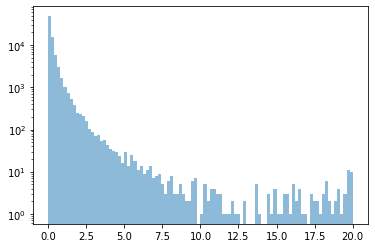

In [35]:
month_34 = all_data[(all_data.date_block_num == 34)&(~all_data.shop_id.isin(closed_shops))&(all_data.item_id.isin(forecastable_items))].fillna(0)
month_34 = pd.merge(month_34, timeline, how='left', on=['date_block_num'])
# shop #51 and #36 are special cases:
month_34 = month_34[(month_34.shop_id!=51)&(month_34.shop_id!=36)]
month_34['item_cnt_month'] = full_model_other.predict(month_34[predictors3])

plt.hist(month_34.item_cnt_month, bins=100, range=[0, 20], alpha=0.5)
plt.yscale('log')
plt.show()

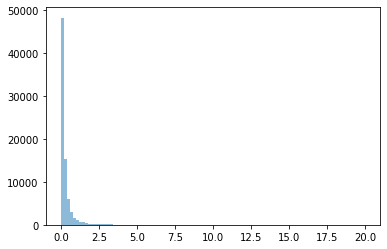

In [36]:
plt.hist(month_34.item_cnt_month, bins=100, range=[0, 20], alpha=0.5)
plt.show()